# Quantum linear system solver

One use of the quantum phase estimation algorithm is to solve systems of linear equations, as first proposed in the famous [HHL algorithm](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502) as will be discussed in this section. The goal of this algorithm is that given $N\times N$ matrix $A$ and vector $\mathbf{b}$ of length $N$ to find vector $\mathbf{x}$ such that:

$$ A\mathbf{x} = \mathbf{b}. $$

Classically, this would typically involve calculating $A^{-1}$ and calculating $A^{-1}\mathbf{b}$ with a complexity of $O(N^{k})$ where $k$ lies between $2-3$.

The HHL algorithm looks to solve an analogous quantum problem where we have a state $|b\rangle$ of $n$ qubits and a $2^n \times 2^n$ unitary operator $\hat{A}$ where we wish to prepare the state $|x\rangle$ such that:

$$ \hat{A}|x\rangle = |b\rangle. $$

At this point it is worth emphasising that, like the comparison between the quantum Fourier transform and the classical discrete Fourier transform, the classical and quantum linear system problems are distinctly different, and require different algorithms to solve. 

The HHL algorithm is performed in four steps:

   1. Prepare state $|b\rangle=\sum^{2^{n}-1}_{j=0}\beta_{j}|u_j\rangle$ on a register of $n$ qubits where $u_j$ are the eigenbases of $A$ and coefficients $\beta_j$.
   
   2. Apply quantum phase estimation algorithm to estimate the eigenvalues of $A$ given $|b\rangle$ and save the result to a second ancillary register of $n_{out}$ qubits to produce state:
   
   $$ \sum^{2^{n}-1}_{j=0}\beta_j|u_j\rangle|\lambda_j\rangle, $$
   
   where $\lambda_j$ are the eigenvalues of $A$ corresponding to the eigenbases $u_j$.
   
   3. Introduce a third register of a single qubit and perform a rotation with a scaling $c$ on this target qubit controlled on the second register to produce the state:
   
   $$ \sum^{2^{n}-1}_{j=0}\beta_j|u_j\rangle|\lambda_j\rangle\left(\sqrt{1-(c\lambda_{j}^{-1})^2}|0\rangle + c\lambda_{j}^{-1}|1\rangle\right). $$
   
   4. Apply the inverse quantum phase estimation algorithm to un-calculate the operation of step 2 to prepare the final state:
   
   $$ \sum^{2^{n}-1}_{j=0}\left(\sqrt{1-(c\lambda_{j}^{-1})^2}\beta_j|0\rangle + c\lambda_{j}^{-1}\beta_j|1\rangle\right)|\lambda_j\rangle. $$
   
The state resulting from step 4, if the target qubit is measured in the state $|1\rangle$, the initial register is left in the (unnormalised) state:

$$ \sum^{2^{n}-1}_{j=0}\lambda_{j}^{-1}\beta_j|\lambda_j\rangle=\hat{A}^{-1}|b\rangle, $$

as desired. Let us now use the quantum phase estimation from the previous notebook to perform the HHL algorithm.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.circuit.library import ExactReciprocal
from qiskit.extensions import HamiltonianGate
from qiskit.quantum_info import random_hermitian
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

We can encode steps 2-4 into the function below (step 1 is performed in advance), where step 3 can be performed by qiskits own `ExactReciprocal` function:

In [3]:
def HHL(circ, qb, qanc, qtarg, A, t=2.*np.pi, scaling=None, wrap=False, inverse=False, phase=True, label='HHL'):
        
    n = len(qb)
    nanc = len(qanc)

    if inverse:
        wrap = True

    if wrap:
        qb = QuantumRegister(n, 'b')
        qanc = QuantumRegister(nanc, 'anc')
        qtarg = QuantumRegister(1, 'targ')
        circ = QuantumCircuit(qb, qanc, qtarg)

    # Define unitary operator given matrix A and evolution time t
    A_gate = HamiltonianGate(A, t)
    
    # Apply phase estimation
    qe_gate = qt.PhaseEst(circ, qb, qanc, A_gate, wrap=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate, [*qb, *qanc]);
        
    # Apply ExactReciprocal to rotate the target qubit proportionally to the given scaling and the inverse of the
    # values stored in the computational basis of the ancillary register
    rec_gate = ExactReciprocal(nanc, scaling=scaling, neg_vals=phase).to_gate()
    circ.append(rec_gate, [*qanc[::-1], qtarg]);

    # Apply the inverse phase estimation
    qe_gate_inv = qt.PhaseEst(circ, qb, qanc, A_gate, wrap=True, inverse=True, do_swaps=False, reverse_bits=True)
    circ.append(qe_gate_inv, [*qb, *qanc]);
    
    if wrap:
        circ = circ.to_gate()
        circ.label = label

    if inverse:
        circ = circ.inverse()
        circ.label = label+'\dag'

    return circ

Let us set the number of qubits of state $|b\rangle$:

In [4]:
n = 2

and produce a random $2^{n}\times2^{n}$ Hermitian matrix:

In [5]:
A = random_hermitian(2**n).to_matrix()
print(A)

[[ 1.10043084+0.j          0.13037837-0.44018997j -0.27957013+0.29272314j
   0.63317033+0.21737848j]
 [ 0.13037837+0.44018997j  0.14759127+0.j         -0.0129562 +0.01565753j
  -0.35900601+0.55504771j]
 [-0.27957013-0.29272314j -0.0129562 -0.01565753j -0.23761652+0.j
  -1.16584858-0.39350631j]
 [ 0.63317033-0.21737848j -0.35900601-0.55504771j -1.16584858+0.39350631j
  -0.42574877+0.j        ]]


Similar to the previous notebook, we will cheat and calculate the minimum and maximum eigenvalues and the corresponding conditioning number $\kappa$. However, we note again that only an estimate of these values are required and not exact values.

In [6]:
lambda_min = np.min(np.abs(np.linalg.eigvals(A)))
lambda_max = np.max(np.abs(np.linalg.eigvals(A)))
kappa = np.abs(lambda_max/lambda_min)

print('Minimum eigenvalue, maximum eigenvalue and conditional number of A:', lambda_min, lambda_max, kappa)

Minimum eigenvalue, maximum eigenvalue and conditional number of A: 0.10918390163740106 1.9476214671340895 17.837991113398072


As before, we will also determine the number of needed ancillary qubits given the relation $n_{anc}\ge n + \lceil\log_2(2 + \frac{1}{2(1-p_{suc}))}\rceil$, where $p_{suc}$ is the probability of returning a close estimate of an eigenvalue from the phase estimation algorithm:

In [7]:
phase = True

# Choose a success probability of determining eigenvalue estimation
p_suc = 0.99
# Determine the number of ancillary qubits to ensure the given success probability
nanc = n + int(np.ceil(np.log2(2. + 1./(2.*(1-p_suc)))))

As before, we determine the optimal evolution time parameter $t_0$ from $\kappa$ and the minimum eigenvalue:

In [8]:
# Calculate the new scale of the relative magnitudes of maximum and minimum eigenvalues
rescale = int((2**(nanc-phase)-1)/kappa)
# Make sure this scaling is not vanishingly small
if rescale < 1.e-7:
    rescale = 1
    
# determine the number of integer qubits required
nint = qt.get_nint(rescale)
# Assert that the number of integer qubits is equal to or greater than the number of ancillary qubits assigned
if nint < nanc - phase:
    nint = nanc - phase
    
# We can determine the scaling of the rotation of step 3 (variable c)
scaling = qt.bin_to_dec(qt.my_binary_repr(rescale, nint=nint, n=nint, phase=False), nint=0, phase=False)
t0 = scaling / (lambda_min * (2**phase))
t = 2 * np.pi * t0

Let us first perform step 1 by defining $|b\rangle$:

In [9]:
qb = QuantumRegister(n, 'b')
circ = QuantumCircuit(qb)

and prepare this state simply as an equal superposition:

In [10]:
circ.h(qb);

In [11]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
in_vector = np.asarray(result.get_statevector())

We can determine the vector form of $b$ to be:

In [12]:
print('The state amplitudes of b are:',in_vector)

The state amplitudes of b are: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


which we can use later to verify our output by comparing it to the target $x$:

In [13]:
targ = np.matmul(np.linalg.inv(A),in_vector)
print('The target state amplitudes of x are:',targ)

The target state amplitudes of x are: [ 1.27187202-0.33323127j -0.71306401+0.1485272j   0.7955263 +0.12079413j
 -0.94818401+0.06390995j]


Now let's define the ancillary and target registers and add them to the circuit:

In [14]:
qanc = QuantumRegister(nanc, 'anc')
qtarg = QuantumRegister(1, 'targ')

circ.add_register(qanc, qtarg)

and applying the HHL algorithm:

In [15]:
circ = HHL(circ, qb, qanc, qtarg, A, t=t, scaling=scaling)

we get the circuit shown below:

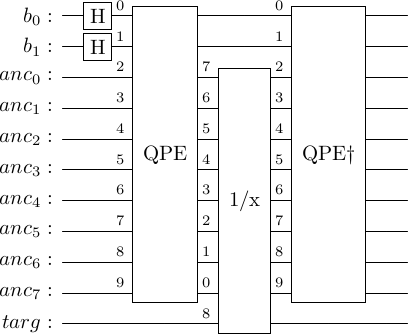

In [16]:
circ.draw('latex')

Now let us take a look at the resulting state:

In [17]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = np.asarray(result.get_statevector())

In [18]:
state_v = np.asarray(state_vector).reshape((2**1,2**nanc,2**n))

In [19]:
# 1, nanc, n
print(state_v.shape)

(2, 256, 4)


We can determine the normalisation coefficient by measuring the probability of measuring the target qubit in state $|1\rangle$:

In [20]:
norm_ = np.sqrt(np.sum(np.abs(state_v[1])**2))
print('The target qubit is in the 1 state with probability:',norm_)

The target qubit is in the 1 state with probability: 0.21436123603378443


Measuring the target qubit in state $|1\rangle$, and the ancillary register in state $|0\rangle^{\otimes n_{anc}}$:

In [21]:
state_v = state_v[1,0]

results in the unnormalised state:

In [22]:
print(state_v)

[ 0.13858273-0.03638431j -0.07790933+0.01609339j  0.08697338+0.01326696j
 -0.10345343+0.00702396j]


Let us renormalize this state:

In [23]:
state_v = np.array(state_v/np.sqrt(np.sum(np.abs(state_v)**2)))

We can rescale these states in order to compare them to the target result:

In [24]:
norm = norm_/lambda_min
out = state_v*norm

print('The amplitudes of the resulting states are:', out)

The amplitudes of the resulting states are: [ 1.2776363 -0.33543797j -0.71826977+0.14836981j  0.80183407+0.12231215j
 -0.9537686 +0.06475601j]


Let us compare the rescaled output states to the target state $|x\rangle$:

In [25]:
print('Ratio of real part of output to target:',out.real/targ.real)
print('Ratio of imaginary part of output to target:',out.imag/targ.imag)

Ratio of real part of output to target: [1.00453212 1.00730055 1.00792905 1.00588977]
Ratio of imaginary part of output to target: [1.00662213 0.99894031 1.01256708 1.01323838]


They should be comparable!